# TM10007 Assignment

In [17]:
# Run this to use from colab environment
#!pip install -q --upgrade git+https://github.com/jveenland/tm10007_ml.git

## Load and analyse data

The number of samples: 246
The number of columns: 494
<class 'pandas.core.frame.DataFrame'>
Index: 246 entries, GIST-001_0 to GIST-246_0
Columns: 494 entries, label to PREDICT_original_phasef_phasesym_entropy_WL3_N5
dtypes: float64(468), int64(25), object(1)
memory usage: 951.3+ KB
None
                                                    PREDICT_original_sf_compactness_avg_2.5D  \
PREDICT_original_sf_compactness_avg_2.5D                                                True   
PREDICT_original_sf_compactness_std_2.5D                                               False   
PREDICT_original_sf_rad_dist_avg_2.5D                                                  False   
PREDICT_original_sf_rad_dist_std_2.5D                                                  False   
PREDICT_original_sf_roughness_avg_2.5D                                                 False   
...                                                                                      ...   
PREDICT_original_phasef_phasesym_peak_po

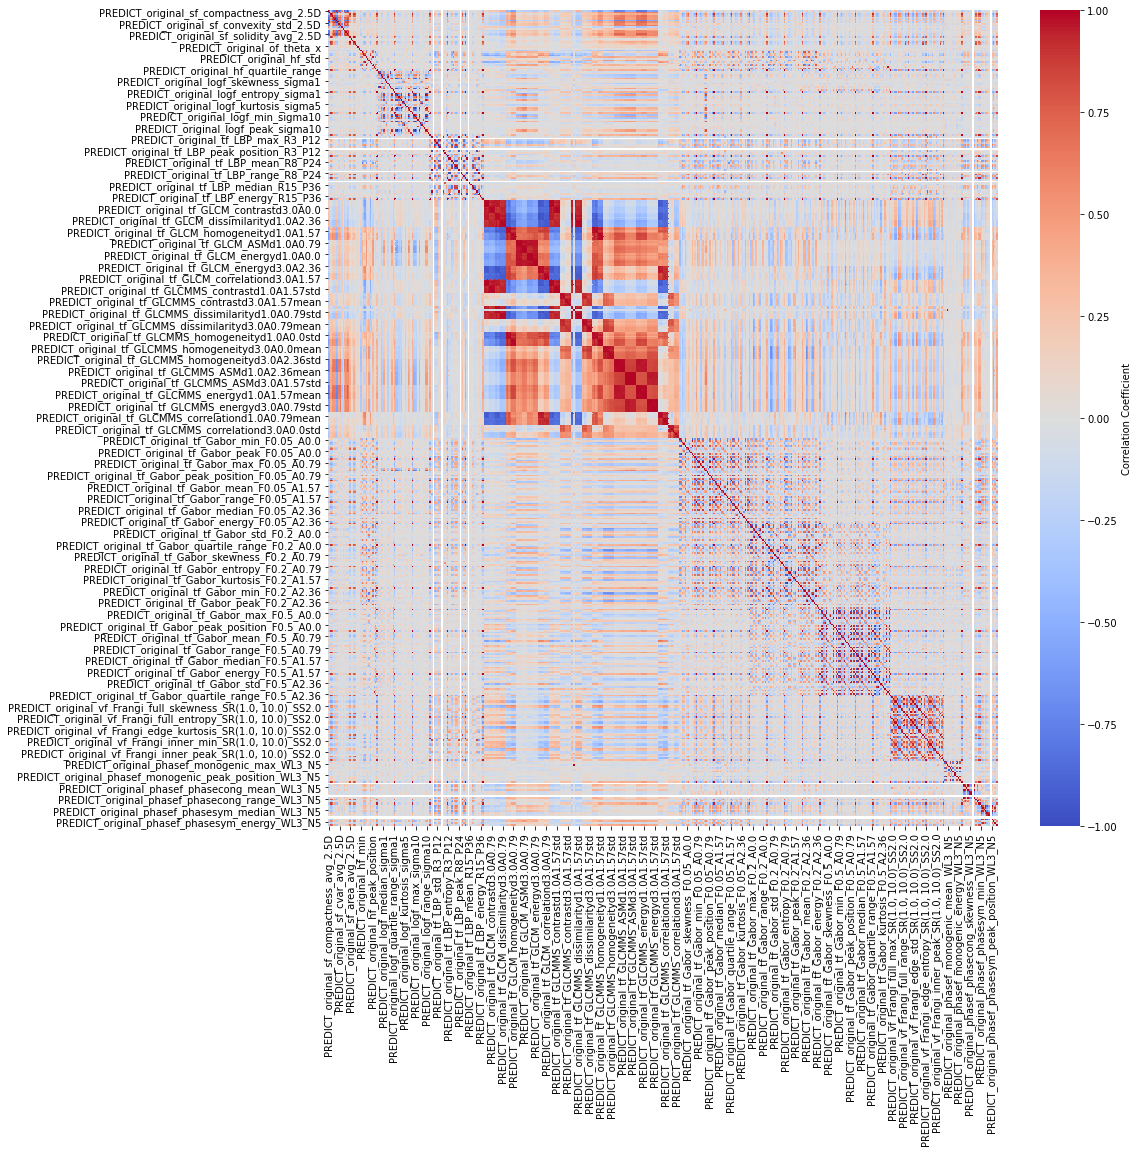

In [18]:
from load_data import load_data
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pandas as pd

# Code used to load the original data and split into train and test set
# Was only run once at the start to create test and train dataset

data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

print(data.info())

# Make a correlation matrix to analyse the correlation between the features
correlation_matrix = data.drop(columns=['label']).corr()

print(correlation_matrix > 0.9)

# Heatmap for the entire correlation matrix (for large datasets, consider reducing the size)
plt.figure(figsize=(15, 15))  # Adjust size as needed
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", cbar_kws={'label': 'Correlation Coefficient'})
plt.show()

# Standardize the data
labels = data['label']
values = data.drop(columns=['label'])

scaler = StandardScaler()
scaled_values = scaler.fit_transform(values)

values = pd.DataFrame(scaled_values, columns=values.columns)

# Convert 'GIST' and 'non-GIST' to numeric values
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)  # This will convert 'GIST' to 1, 'non-GIST' to 0


## Feature selection and dimension reduction

In [19]:
# First we remove NaNs by averaging
values = values.fillna(values.mean())

# First we remove features with 0 variance
print(values.shape)

print(f'We removed {values.loc[:, values.var() == 0].shape[1]} columns without any variance')
values = values.loc[:, values.var() != 0]

print(values.shape)



(246, 493)
We removed 13 columns without any variance
(246, 480)


## Elastic net selection

In [ ]:
from sklearn.linear_model import LogisticRegressionCV
import numpy as np

def elastic_net_feature_selection(training_values, training_labels):

    elastic_net = LogisticRegressionCV(
    penalty="elasticnet",
    solver="saga",         
    l1_ratios=[0.1, 0.5, 0.9],  
    cv=5,                 
    max_iter=5000,         
    random_state=42
    )   

    elastic_net.fit(training_values, training_labels)

    print(elastic_net.coef_)

    selected_features = np.where(elastic_net.coef_ != 0)[0]

    print(f"Selected features: {selected_features}")

    training_values = training_values.iloc[:, selected_features]

    return training_values, training_labels

## Random forest

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

def train_random_forest(training_values, training_labels):
    # Initialize the Random Forest Classifier
    rf_model = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        max_features='sqrt',
        min_samples_leaf=5,
        random_state=42
    )

    trained_model = rf_model.fit(training_values, training_labels)

    feature_importances = trained_model.feature_importances_

    feature_importance_df = pd.DataFrame({
        'Feature': training_values.columns,
        'Importance': feature_importances
    })

    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)

    top_features = feature_importance_df.head(20)['Feature'].values

    data_selected = training_values[top_features]
    labels_selected = training_labels

    final_model = rf_model.fit(data_selected, labels_selected)
    cv_scores = cross_val_score(rf_model, data_selected, labels_selected, cv=5)

    return final_model, cv_scores.mean()

## KNN-classifier

In [23]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy.stats import randint
import pandas as pd

# Laad de data
data = load_data()

# Labels en features splitsen
labels = data['label']
values = data.drop(columns=['label'])

# Standaardiseren van de features
scaler = StandardScaler()
training_values = scaler.fit_transform(values)

# Labels encoderen
label_encoder = LabelEncoder()
training_labels = label_encoder.fit_transform(labels)

# Debugging: Controleer of de variabelen correct zijn
print("training_values shape:", training_values.shape)  # Moet (246, X) zijn
print("training_labels shape:", training_labels.shape)  # Moet (246,)

# Definieer de hyperparameter-zoekruimte
param_dist = {
    'n_neighbors': randint(1, 100),
    'weights': ['uniform', 'distance']
}

# Maak een KNN-classifier
knn = KNeighborsClassifier()

# Randomized Search met Cross-Validation
random_search = RandomizedSearchCV(
    knn,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)

# Train het model met RandomizedSearch
random_search.fit(training_values, training_labels)

# Print de beste parameters en score
print("Beste hyperparameters:", random_search.best_params_)
print("Beste cross-val score:", random_search.best_score_)

# Gebruik het beste model
best_knn = random_search.best_estimator_

training_values shape: (246, 493)
training_labels shape: (246,)
Beste hyperparameters: {'n_neighbors': 24, 'weights': 'uniform'}
Beste cross-val score: 0.6298775510204082


## SVM

In [ ]:
from sklearn.svm import SVC

def SVM(training_values, training_labels):
    training_values, training_labels = elastic_net_feature_selection(training_values, training_labels)

    # Initialiseren van de SVM-classifiers
    clf = SVC(kernel='linear', gamma='scale')
    #svmrbf = SVC(kernel='rbf', gamma='scale')
    #svmpoly = SVC(kernel='poly', degree=3, gamma='scale')

    clf.fit(training_values, training_labels)  # Train het model op de gehele dataset
        
    cv_scores = cross_val_score(clf, training_values, training_labels, cv=5)

    return cv_scores.mean()

## Linear classifier

In [ ]:
# Linear classifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score,f1_score
from load_data import load_data

def linear_classifier(training_values,training_labels):
    # # === LDA model trainen ===
    lda = LinearDiscriminantAnalysis()
    lda.fit(training_values, training_labels)  # Model trainen met training set
    
    # === Model voorspellingen maken ==
    y_pred_train = lda.predict(training_values)  # Voorspellen op de training set
    y_probs_train = lda.predict_proba(training_values)[:, 1]  # Voor ROC-AUC (trainset)
    
    # Evaluatiemetrics berekenen voor training set
    accuracy_train = accuracy_score(training_labels, y_pred_train)
    precision_train = precision_score(training_labels, y_pred_train)
    recall_train = recall_score(training_labels, y_pred_train)
    f1_train = f1_score(training_labels, y_pred_train)
    roc_auc_train = roc_auc_score(training_labels, y_probs_train)
    # Print de resultaten voor zowel training als test set
    print(f"🔹 **LDA Model Evaluatie (Training Set):**")
    print(f"   Accuracy:  {accuracy_train:.4f}")
    print(f"   Precision: {precision_train:.4f}")
    print(f"   Recall:    {recall_train:.4f}")
    print(f"   F1-score:  {f1_train:.4f}")
    print(f"   ROC-AUC:   {roc_auc_train:.4f}")
    
    return accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


## Try the different classifiers for 5 different folds

In [ ]:
from sklearn.model_selection import StratifiedKFold

# 5-fold cross-validation setup
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_index, test_index) in enumerate(skf.split(values, labels)):
    print(f"\n=== Fold {fold} ===")

    training_values = values.iloc[train_index]
    training_labels = labels[train_index]

    print(training_labels)

    test_values = values.iloc[test_index]
    test_labels = labels[test_index]

    forest_model, forest_score = train_random_forest(training_values, training_labels)
    print(f"Fold {fold} - Random Forest Score: {forest_score:.4f}")

    knn_score = KNN(training_values, training_labels)
    print(f"Fold {fold} - KNN Score: {knn_score:.4f}")

    svm_score = SVM(training_values, training_labels)
    print(f"Fold {fold} - SVM Score: {svm_score:.4f}")
    
#)


=== Fold 0 ===
[1 0 1 0 0 0 0 0 1 1 1 0 0 1 1 0 0 0 0 1 1 1 1 0 0 1 0 0 0 1 0 1 1 0 1 0 1
 1 0 0 0 0 0 1 1 0 1 0 1 1 0 0 0 1 1 1 0 0 0 0 1 0 0 0 0 1 1 1 1 1 0 1 0 0
 0 1 0 1 0 1 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 0 1 0 1 0 1
 1 0 0 1 1 1 1 1 0 1 1 0 1 1 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 1 1 0 1 1 0
 0 1 1 0 0 0 1 0 0 0 1 0 1 1 0 0 1 0 1 0 0 1 0 1 0 1 0 0 1 1 0 1 0 0 0 1 1
 1 0 1 0 0 0 0 1 0 0 1]
Fold 0 - Random Forest Score: 0.5558


c:\Users\lisan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\lisan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\lisan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\lisan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\lisan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\lisan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

[[ 4.37794313e-02 -9.89877789e-02 -1.01751747e-02 -2.72207260e-01
  -4.24914989e-01 -9.23330883e-02 -3.91182549e-02  9.63703475e-02
   9.83197346e-02  0.00000000e+00  4.82602295e-02 -2.54873845e-01
   2.29685974e-01  3.82191843e-01  6.37202816e-02 -6.93540088e-02
  -2.23684284e-01  1.21673142e-01 -2.73994806e-01 -2.89984327e-01
   1.05690141e-03  7.87706133e-02 -4.40489717e-01 -6.26505526e-03
  -8.51831808e-02 -2.16941535e-01 -2.43952627e-02  6.93673645e-02
  -4.23990217e-02  3.22714079e-01 -4.49152458e-02 -5.55277469e-02
  -4.04681207e-01 -8.31812119e-02  0.00000000e+00 -1.79448042e-01
   4.96644704e-02  4.81018888e-02  3.27210334e-01 -5.36524278e-02
   3.82537228e-02  4.47104507e-02  1.87507950e-01 -1.37991367e-01
  -9.56856808e-02  1.41305732e-03  1.06676133e-01  0.00000000e+00
  -3.58341845e-02  5.00909908e-02 -4.63673482e-02  5.73184379e-02
   1.03673079e-02  1.42600110e-01  1.48892662e-01 -9.61097694e-02
   0.00000000e+00  1.42857249e-01  1.65196529e-01  5.22872111e-02
   5.91142

c:\Users\lisan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\lisan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\lisan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\lisan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\lisan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\lisan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

[[ 4.37794313e-02 -9.89877789e-02 -1.01751747e-02 -2.72207260e-01
  -4.24914989e-01 -9.23330883e-02 -3.91182549e-02  9.63703475e-02
   9.83197346e-02  0.00000000e+00  4.82602295e-02 -2.54873845e-01
   2.29685974e-01  3.82191843e-01  6.37202816e-02 -6.93540088e-02
  -2.23684284e-01  1.21673142e-01 -2.73994806e-01 -2.89984327e-01
   1.05690141e-03  7.87706133e-02 -4.40489717e-01 -6.26505526e-03
  -8.51831808e-02 -2.16941535e-01 -2.43952627e-02  6.93673645e-02
  -4.23990217e-02  3.22714079e-01 -4.49152458e-02 -5.55277469e-02
  -4.04681207e-01 -8.31812119e-02  0.00000000e+00 -1.79448042e-01
   4.96644704e-02  4.81018888e-02  3.27210334e-01 -5.36524278e-02
   3.82537228e-02  4.47104507e-02  1.87507950e-01 -1.37991367e-01
  -9.56856808e-02  1.41305732e-03  1.06676133e-01  0.00000000e+00
  -3.58341845e-02  5.00909908e-02 -4.63673482e-02  5.73184379e-02
   1.03673079e-02  1.42600110e-01  1.48892662e-01 -9.61097694e-02
   0.00000000e+00  1.42857249e-01  1.65196529e-01  5.22872111e-02
   5.91142

c:\Users\lisan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\lisan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\lisan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\lisan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\lisan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\lisan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -6.00387226e-02
  -1.16570518e-01  0.00000000e+00  0.00000000e+00  8.63830921e-03
   0.00000000e+00  3.12749764e-02  6.35840120e-03 -2.27292519e-01
   6.15094077e-02  2.87372242e-01  3.32704488e-02  0.00000000e+00
  -7.60971912e-02  7.32499852e-02  0.00000000e+00 -2.24449572e-01
   0.00000000e+00  0.00000000e+00 -3.14468512e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  1.89677773e-01  0.00000000e+00  0.00000000e+00
  -1.28699124e-02  0.00000000e+00  0.00000000e+00 -2.80077579e-01
   0.00000000e+00 -5.79607377e-02  1.13358325e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00 -9.91458852e-02
   0.00000000e+00  0.00000000e+00  8.98550995e-02  0.00000000e+00
   2.74758292e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  8.50043514e-02  9.54241774e-03 -2.64349230e-01
   0.00000000e+00  0.00000000e+00  2.16078483e-02  0.00000000e+00
   0.00000

c:\Users\lisan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\lisan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\lisan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\lisan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\lisan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\lisan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -6.00387226e-02
  -1.16570518e-01  0.00000000e+00  0.00000000e+00  8.63830921e-03
   0.00000000e+00  3.12749764e-02  6.35840120e-03 -2.27292519e-01
   6.15094077e-02  2.87372242e-01  3.32704488e-02  0.00000000e+00
  -7.60971912e-02  7.32499852e-02  0.00000000e+00 -2.24449572e-01
   0.00000000e+00  0.00000000e+00 -3.14468512e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  1.89677773e-01  0.00000000e+00  0.00000000e+00
  -1.28699124e-02  0.00000000e+00  0.00000000e+00 -2.80077579e-01
   0.00000000e+00 -5.79607377e-02  1.13358325e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00 -9.91458852e-02
   0.00000000e+00  0.00000000e+00  8.98550995e-02  0.00000000e+00
   2.74758292e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  8.50043514e-02  9.54241774e-03 -2.64349230e-01
   0.00000000e+00  0.00000000e+00  2.16078483e-02  0.00000000e+00
   0.00000

c:\Users\lisan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\lisan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\lisan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\lisan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\lisan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\lisan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

[[ 0.00000000e+00  0.00000000e+00 -2.49399844e-02 -2.77702045e-02
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -2.17047648e-02  0.00000000e+00  0.00000000e+00 -2.77378330e-02
  -7.12720781e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -2.04909670e-04  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000

c:\Users\lisan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\lisan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\lisan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\lisan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\lisan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\lisan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

[[ 0.00000000e+00  0.00000000e+00 -2.49399844e-02 -2.77702045e-02
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -2.17047648e-02  0.00000000e+00  0.00000000e+00 -2.77378330e-02
  -7.12720781e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -2.04909670e-04  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000

c:\Users\lisan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\lisan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\lisan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\lisan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\lisan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\lisan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

[[ 2.82296757e-02 -4.69076761e-02 -7.50449495e-03 -2.17508071e-01
  -1.32249824e-01 -3.57622618e-02 -4.42262621e-02  4.51954010e-02
   1.23174675e-02  2.29872824e-02  0.00000000e+00 -2.39135737e-01
   6.41603192e-02  3.07499220e-01  7.67161871e-02  1.59878568e-01
  -1.34212347e-01  1.53556604e-01 -8.60057581e-02 -2.53706345e-01
   2.44863198e-02  6.32882574e-02 -3.18946526e-01 -6.05251012e-03
   8.93900294e-03 -7.44301198e-02  4.01016663e-02  5.08403791e-02
  -1.22265032e-01  3.17773962e-01 -1.08560039e-01  4.12778178e-02
  -2.94943088e-01 -7.45992097e-02  0.00000000e+00 -2.32078965e-01
   3.44056247e-02 -1.35491991e-01  3.24531927e-01 -9.10580330e-02
   8.96668518e-02  1.00049020e-02 -1.24004395e-02 -1.49372097e-01
   1.17613794e-02  1.18347236e-01  2.25988770e-01 -2.38860822e-02
  -2.18988889e-02  3.47757988e-02  0.00000000e+00  1.01002295e-02
   7.15190893e-02  9.17404781e-02  1.13562894e-01 -2.90911112e-01
   5.59178207e-02  0.00000000e+00  2.46733825e-01  1.87265971e-03
   0.00000

c:\Users\lisan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\lisan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\lisan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\lisan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\lisan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\lisan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

[[ 2.82296757e-02 -4.69076761e-02 -7.50449495e-03 -2.17508071e-01
  -1.32249824e-01 -3.57622618e-02 -4.42262621e-02  4.51954010e-02
   1.23174675e-02  2.29872824e-02  0.00000000e+00 -2.39135737e-01
   6.41603192e-02  3.07499220e-01  7.67161871e-02  1.59878568e-01
  -1.34212347e-01  1.53556604e-01 -8.60057581e-02 -2.53706345e-01
   2.44863198e-02  6.32882574e-02 -3.18946526e-01 -6.05251012e-03
   8.93900294e-03 -7.44301198e-02  4.01016663e-02  5.08403791e-02
  -1.22265032e-01  3.17773962e-01 -1.08560039e-01  4.12778178e-02
  -2.94943088e-01 -7.45992097e-02  0.00000000e+00 -2.32078965e-01
   3.44056247e-02 -1.35491991e-01  3.24531927e-01 -9.10580330e-02
   8.96668518e-02  1.00049020e-02 -1.24004395e-02 -1.49372097e-01
   1.17613794e-02  1.18347236e-01  2.25988770e-01 -2.38860822e-02
  -2.18988889e-02  3.47757988e-02  0.00000000e+00  1.01002295e-02
   7.15190893e-02  9.17404781e-02  1.13562894e-01 -2.90911112e-01
   5.59178207e-02  0.00000000e+00  2.46733825e-01  1.87265971e-03
   0.00000

c:\Users\lisan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\lisan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\lisan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\lisan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\lisan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\lisan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

[[ 0.00000000e+00  9.11768132e-04  0.00000000e+00 -2.63774350e-03
   0.00000000e+00  0.00000000e+00  0.00000000e+00  5.41824149e-02
   0.00000000e+00  0.00000000e+00  0.00000000e+00 -8.44047894e-02
   0.00000000e+00  1.21896624e-01  0.00000000e+00  0.00000000e+00
  -2.25710695e-02  5.28739898e-02 -1.18887560e-01 -3.73100929e-02
   0.00000000e+00  3.29311219e-02 -9.63582283e-02  3.27541844e-02
   0.00000000e+00 -2.09135131e-02  0.00000000e+00  0.00000000e+00
  -6.62130959e-02  7.98904113e-02 -1.99750676e-02  0.00000000e+00
  -2.59149833e-02 -3.35399707e-02  0.00000000e+00 -1.33651500e-01
   1.23867108e-03 -7.01734360e-02  8.12261364e-02  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -8.86900370e-02  7.81116337e-02  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  8.02381301e-02  4.17441683e-03 -1.57526644e-01
   0.00000000e+00  3.35147485e-02  1.39106378e-01  0.00000000e+00
   0.00000

c:\Users\lisan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\lisan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\lisan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\lisan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\lisan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\lisan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

[[ 0.00000000e+00  9.11768132e-04  0.00000000e+00 -2.63774350e-03
   0.00000000e+00  0.00000000e+00  0.00000000e+00  5.41824149e-02
   0.00000000e+00  0.00000000e+00  0.00000000e+00 -8.44047894e-02
   0.00000000e+00  1.21896624e-01  0.00000000e+00  0.00000000e+00
  -2.25710695e-02  5.28739898e-02 -1.18887560e-01 -3.73100929e-02
   0.00000000e+00  3.29311219e-02 -9.63582283e-02  3.27541844e-02
   0.00000000e+00 -2.09135131e-02  0.00000000e+00  0.00000000e+00
  -6.62130959e-02  7.98904113e-02 -1.99750676e-02  0.00000000e+00
  -2.59149833e-02 -3.35399707e-02  0.00000000e+00 -1.33651500e-01
   1.23867108e-03 -7.01734360e-02  8.12261364e-02  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -8.86900370e-02  7.81116337e-02  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  8.02381301e-02  4.17441683e-03 -1.57526644e-01
   0.00000000e+00  3.35147485e-02  1.39106378e-01  0.00000000e+00
   0.00000

c:\Users\lisan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
